### MNIST dataset classification using LSTM

We've 60k training images and 10k testing images.

Subsequently, we'll have 3 groups: training, validation and testing for a more robust evaluation of algorithms.

#### Steps
Step 1: Load Dataset

Step 2: Make Dataset Iterable

Step 3: Create Model Class

Step 4: Instantiate Model Class

Step 5: Instantiate Loss Class

Step 6: Instantiate Optimizer Class

Step 7: Train Model

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

    Load Dataset

In [3]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Using downloaded and verified file: ./data\MNIST\raw\train-images-idx3-ubyte.gz
Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1376601.70it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 651991.13it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
print(train_dataset.train_data.size())

torch.Size([60000, 28, 28])


C:\Users\ANAM SURI\AppData\Roaming\Python\Python310\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [5]:
print(train_dataset.train_labels.size())

torch.Size([60000])


C:\Users\ANAM SURI\AppData\Roaming\Python\Python310\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
print(test_dataset.test_data.size())

print(test_dataset.test_labels.size())

torch.Size([10000, 28, 28])
torch.Size([10000])


C:\Users\ANAM SURI\AppData\Roaming\Python\Python310\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\ANAM SURI\AppData\Roaming\Python\Python310\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


    Making Dataset Iterable

In [8]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

    Defining/ Creating LSTM model class

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building LSTM
        # batch_first=True causes input/output tensors to be of shape : (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

    Instantiate Model class

--> 28 time steps
Each time step: input dimension = 28


--> 1 hidden layer, you can define 2, 3 or many more, by changing, layer_dim =2 or 3


--> MNIST 1-9 digits, therefore, output dimension=10



In [10]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

    Instantiate Loss class
Because we are doing a classification problem we'll be using a Cross Entropy function. If we were to do a regression problem, then we would typically use a MSE function


In [11]:
criterion = nn.CrossEntropyLoss()

    Instantiate Optimizer class

In [12]:
# Mini-batch Stochastic Gradient Descent
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
'''We will have 6 groups of parameters here comprising weights and biases from:
 - Input to Hidden Layer Affine Function - Hidden Layer to Output Affine Function - Hidden Layer to Hidden Layer Affine Function
'''
len(list(model.parameters()))

6

In [14]:
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 28])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])


    Training Model

Process:

--> Convert inpt/labels to variables

--> Clear gradient buffers

--> Get output given inputs

--> Get loss

--> Get gradients w.r.t parameters

--> Update parameters using gradients: parameters = parameters - learning_rate * parameters_gradients

--> Repeat


In [15]:
# Number of steps to unroll
seq_dim = 28  

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Resize images
                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.279259443283081. Accuracy: 20.84000015258789
Iteration: 1000. Loss: 1.168777585029602. Accuracy: 59.36000061035156
Iteration: 1500. Loss: 0.583256185054779. Accuracy: 86.12999725341797
Iteration: 2000. Loss: 0.28895634412765503. Accuracy: 90.41000366210938
Iteration: 2500. Loss: 0.14447365701198578. Accuracy: 94.12000274658203
Iteration: 3000. Loss: 0.21504394710063934. Accuracy: 95.56999969482422


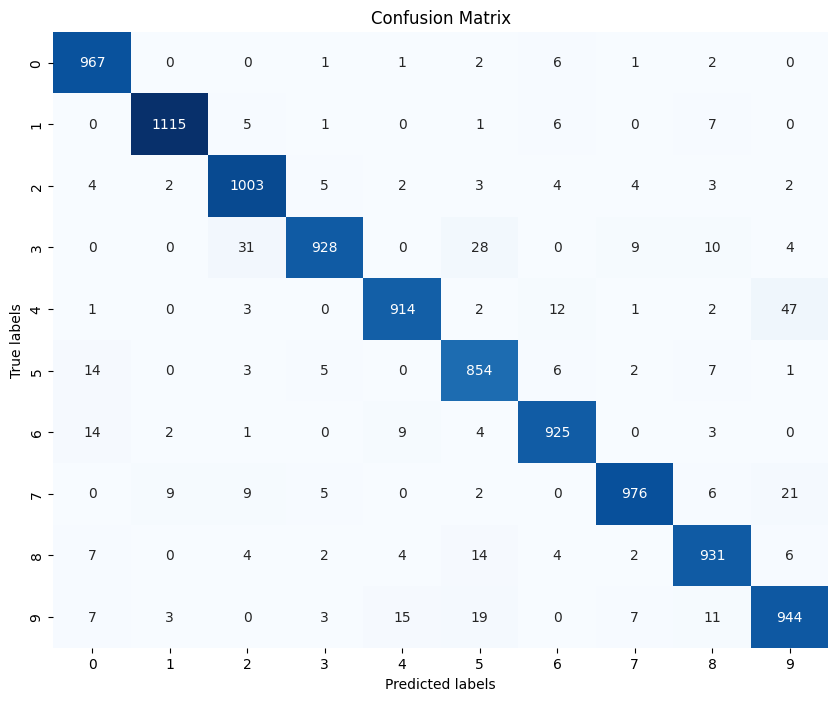

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset
for images, labels in test_loader:
    # Resize images
    images = images.view(-1, seq_dim, input_dim)
    
    # Forward pass to get logits/output
    outputs = model(images)
    
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
    
    # Append true labels and predicted labels to the lists
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted.numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
